In [1]:
import pandas as pd
df = pd.read_pickle("twitts")
df.index = [i for i in range(len(df))]


### Pre-processing tweets

Провести обработку текста:

    -удалить стоп-слова 0
    -найти обращения по @ или хэштеги
    -найти ссылки на сайты
    -разбить по словам и n-граммы


Вопрос 1 Зачем в данном случае нужны n-граммы?

In [2]:
import re
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
import time

start_time = time.time() 

tokenizer = TweetTokenizer()
tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]

stop_words = stopwords.words("english")
stop_words.extend(["&amp;", "&gt;", "&lt;"])
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

clean_text = []
handles = []
hashtags = []
carrier = []
links = []
# простой пример pre-processing
for tweet in tokenized_tweets:

    thandles = []
    thashtags = []
    joined_words = " "
    words = [w.lower() for w in tweet if len(w)>2 and w not in stop_words]
    thandles = [w for w in words if re.search("^@\w+", w)]
    tlinks = [w for w in words if re.search("^https:\w+", w)]
#     print(tlinks)
    thashtags = [w for w in words if re.search("^#\w+", w)]
    words = [w for w in words if w.isalpha() and w not in thandles and w not in thashtags and w not in tlinks]
    words = [lemmatizer.lemmatize(w) for w in words]
    
    joined_words = joined_words.join(words)
    tlength = len(joined_words)
    handles.append(thandles)
    hashtags.append(thashtags)
    links.append(tlinks)
    clean_text.append(joined_words)

In [4]:
df['clean_text'] = clean_text
df['handles'] = handles
df['hashtags'] = hashtags
df['links'] = links
df.head()

,screen_name,date_time,location,text,clean_text,handles,hashtags,links
0,TheSkubis,2021-03-30 23:59:19,"Pennsylvania, USA",@VerizonSupport I have issues with closed capt...,issue closed caption walking dead show display...,[@verizonsupport],[],[]
1,VerizonSupport,2021-03-30 23:56:55,,@_carolinek This could be due to regional rest...,this could due regional restriction have check...,[@_carolinek],[],[]
2,VerizonSupport,2021-03-30 23:55:30,,@tvmurray We'll be happy to help with anything...,happy help anything related fios twitter pleas...,[@tvmurray],[],[]
3,_carolinek,2021-03-30 23:55:24,,@VerizonSupport Hi! I know you think you can h...,know think help literally month trying help th...,[@verizonsupport],[],[]
4,VerizonSupport,2021-03-30 23:54:26,,@lam3014 We will be happy to look into this fo...,happy look please send direct message follow v...,[@lam3014],[],[]


In [5]:
# n-grams
import nltk
# nltk.download('wordnet')
from nltk import ngrams
import collections as c
all_grams = []
for string in df.text:
    gram_2 = []
    for i in ngrams(string.split(),2):
#         print(i)
        gram_2.append(i)
    all_grams.append(gram_2)
df['all_grams'] = all_grams
df.head()

,screen_name,date_time,location,text,clean_text,handles,hashtags,links,all_grams
0,TheSkubis,2021-03-30 23:59:19,"Pennsylvania, USA",@VerizonSupport I have issues with closed capt...,issue closed caption walking dead show display...,[@verizonsupport],[],[],"[(@VerizonSupport, I), (I, have), (have, issue..."
1,VerizonSupport,2021-03-30 23:56:55,,@_carolinek This could be due to regional rest...,this could due regional restriction have check...,[@_carolinek],[],[],"[(@_carolinek, This), (This, could), (could, b..."
2,VerizonSupport,2021-03-30 23:55:30,,@tvmurray We'll be happy to help with anything...,happy help anything related fios twitter pleas...,[@tvmurray],[],[],"[(@tvmurray, We'll), (We'll, be), (be, happy),..."
3,_carolinek,2021-03-30 23:55:24,,@VerizonSupport Hi! I know you think you can h...,know think help literally month trying help th...,[@verizonsupport],[],[],"[(@VerizonSupport, Hi!), (Hi!, I), (I, know), ..."
4,VerizonSupport,2021-03-30 23:54:26,,@lam3014 We will be happy to look into this fo...,happy look please send direct message follow v...,[@lam3014],[],[],"[(@lam3014, We), (We, will), (will, be), (be, ..."


### Разработка сегментов

### Вопрос 1. - какие еще могут быть сегменты?

*Добавил субъективность

https://core.ac.uk/download/pdf/82425196.pdf

In [ ]:
# pip install textblob

In [6]:

# изучить textblob
# https://textblob.readthedocs.io/en/dev/

from textblob import TextBlob
polarity = [0.0]*len(df)
subjectivity = [0.5]*len(df)
sentiment = [""]*len(df)
fact = [""]*len(df)
for i in df.index:
#     print(df.clean_text[i])
    blob = TextBlob(str(df.clean_text[i]))
    polarity[i] = blob.polarity
    subjectivity[i] = blob.subjectivity
    
#     # разбивки на сегменты 
#     # а какие способы ты знаешь ещё?
    if polarity[i] > 0.0:
        sentiment[i] = "pos"
    elif polarity[i] < 0.0:
        sentiment[i] = "neg"
    else:
        sentiment[i] = "neu"
        
    if subjectivity[i] > 0.5:
        fact[i] = 0
    else:
        fact[i] = 1
    
df["sentiment"]    = sentiment
df["polarity"]     = polarity
df["subjectivity"] = subjectivity
df['fact'] = fact

### Вопрос 2. - нужен ли emoji analysis???

  -https://pypi.org/project/emosent-py/
  
  -https://github.com/ajinkyachavan/Emoticon-Based-Sentiment-Analysis-Python/blob/master/emoticon-based-sentiment-analysis-of-twitter-data.pdf

In [7]:
emoji = []
for i in df.text:
    emo = re.findall(r'[^\w\s,-@\'\^…’!#$)(+*“&”~|%]',i)
    emoji.append(emo)
df['emoji'] = emoji


### Сделаем разбивку по операторам



###  Вопрос 3. В чем смысл этой функции, если мы загружали данные через tweepy  изначально по операторам?

In [60]:
# создадим колонку, которая укажет, какой это оператор

# def carrier(df,name):
#     carrier = []

#     for text in df[['screen_name','text']].values:
#         screen_name = text[0].lower()
#         twitter_text = text[1].lower()
#         current_carrier = []
#         if name.lower() in twitter_text or name.lower() in screen_name:
#             current_carrier.append(name)

#         ... 
#         carrier.append(' '.join(current_carrier))
#     df['carrier'] = carrier
#     return df



In [8]:
carrier = []
def carrier (df,name):
    for text in df[['screen_name','text']].values:
        screen_name = text[0].lower()
        twitter_text = text[1].lower()
        current_carrier = []
        if name.lower() in twitter_text or name.lower() in screen_name:
            df.loc[df[df['text'] == text[1]].index,'carrier'] = name
    return df

# df = carrier(df,'VZWSupport')
# df.head()

In [9]:
car = ['verizon','VerizonSupport','VZWSupport','ATT','ATTHelp','TMobile','TMobileHelp']
for i in car:
    df = carrier(df,i)
#     print(df['carrier'].unique())

###  Вопрос 4.зачем эта часть кода - токенайзер делали выше?

In [ ]:
# сделай какой-нибудь токинайзер
# https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BA%D1%81%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B9_%D0%B0%D0%BD%D0%B0%D0%BB%D0%B8%D0%B7
# https://docs.python.org/3/library/tokenize.html

# tokenized_tweets = [tokenizer.tokenize(t) for t in df.text]
# clf_text = []
# for tweet in tokenized_tweets:
#     joined_words = " "
#     words = [w.lower() for w in tweet if w.isalpha() or w[0]=='@']
#     tlinks = [w for w in words if re.search("^https:\w+", w)]
#     words = [w for w in words if  w not in tlinks]
#     joined_words = joined_words.join(words)
#     clf_text.append(joined_words)

# df["clf_text"] = clf_text

### Сделай обзор по группам (EDA)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt 

In [11]:
clean_df = df[~df['carrier'].isna()][['carrier','location','date_time','clean_text','sentiment','fact','emoji']]
clean_df

,carrier,location,date_time,clean_text,sentiment,fact,emoji
0,VerizonSupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,neg,1,[]
1,VerizonSupport,,2021-03-30 23:56:55,this could due regional restriction have check...,neg,1,[]
2,VerizonSupport,,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,pos,0,[]
3,VerizonSupport,,2021-03-30 23:55:24,know think help literally month trying help th...,neu,1,[]
4,VerizonSupport,,2021-03-30 23:54:26,happy look please send direct message follow v...,pos,0,[]
...,...,...,...,...,...,...,...
695,TMobileHelp,Erie PA,2021-03-30 22:40:49,line though and referring,neu,1,[]
696,TMobileHelp,"Bellevue, WA",2021-03-30 22:40:01,hey experience super important want make sure ...,pos,0,[]
697,TMobileHelp,"Bellevue, WA",2021-03-30 22:39:22,thank reaching today ryan the essential plan a...,neu,1,[]
698,TMobileHelp,"Bellevue, WA",2021-03-30 22:36:19,committed providing reliable service need stay...,neu,1,[]


In [12]:
# добавим месяц,час,dummy-переменную sentiment и длину текстового сообщения

import datetime as dt
clean_df['month'] = clean_df['date_time'].dt.month
clean_df['hour'] = clean_df['date_time'].dt.hour
clean_df['sense_dummy'] = clean_df['sentiment'].apply(lambda x: 1 if x == 'pos' else (0 if x == 'neu' else -1))
clean_df['text_len'] = clean_df['clean_text'].apply(lambda x:len(x))
clean_df.drop('sentiment',inplace = True,axis = 1)
clean_df['len_emoji'] = clean_df['emoji'].apply(lambda x:len(x))
clean_df['day'] = df['date_time'].dt.weekday
clean_df.head(3)

,carrier,location,date_time,clean_text,fact,emoji,month,hour,sense_dummy,text_len,len_emoji,day
0,VerizonSupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,1,[],3,23,-1,51,0,1
1,VerizonSupport,,2021-03-30 23:56:55,this could due regional restriction have check...,1,[],3,23,-1,52,0,1
2,VerizonSupport,,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,0,[],3,23,1,63,0,1


In [13]:
clean_df.describe()


,fact,month,hour,sense_dummy,text_len,len_emoji,day
count,649.000000,649.0,649.000000,649.000000,649.000000,649.000000,649.0
mean,0.704160,3.0,22.306626,0.229584,46.661017,0.280431,1.0
std,0.456771,0.0,1.031885,0.676766,19.779004,1.163330,0.0
min,0.000000,3.0,19.000000,-1.000000,0.000000,0.000000,1.0
25%,0.000000,3.0,22.000000,0.000000,37.000000,0.000000,1.0
50%,1.000000,3.0,23.000000,0.000000,48.000000,0.000000,1.0
75%,1.000000,3.0,23.000000,1.000000,60.000000,0.000000,1.0
max,1.000000,3.0,23.000000,1.000000,106.000000,14.000000,1.0


In [14]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 649 entries, 0 to 699
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   carrier      649 non-null    object        
 1   location     649 non-null    object        
 2   date_time    649 non-null    datetime64[ns]
 3   clean_text   649 non-null    object        
 4   fact         649 non-null    int64         
 5   emoji        649 non-null    object        
 6   month        649 non-null    int64         
 7   hour         649 non-null    int64         
 8   sense_dummy  649 non-null    int64         
 9   text_len     649 non-null    int64         
 10  len_emoji    649 non-null    int64         
 11  day          649 non-null    int64         
dtypes: datetime64[ns](1), int64(7), object(4)
memory usage: 65.9+ KB


In [15]:
# описание по среднему и count
clean_df.groupby('carrier').agg(['count','mean'])

fact           month       hour            sense_dummy  \
               count      mean count mean count       mean       count   
carrier                                                                  
ATT               93  0.709677    93    3    93  22.623656          93   
ATTHelp           98  0.846939    98    3    98  21.459184          98   
TMobile           96  0.875000    96    3    96  22.927083          96   
TMobileHelp      110  0.518182   110    3   110  22.718182         110   
VZWSupport        96  0.614583    96    3    96  21.614583          96   
VerizonSupport    88  0.613636    88    3    88  21.943182          88   
verizon           68  0.794118    68    3    68  23.000000          68   

                         text_len            len_emoji             day       
                    mean    count       mean     count      mean count mean  
carrier                                                                      
ATT             0.236559       93  40.129032        93  0.548387    93    1  
ATTHelp         0.132653       98  52.418367        98  0.030612    98    1  
TMobile         0.208333       96  41.572917        96  0.625000    96    1  
TMobileHelp     0.363636      110  47.972727       110  0.163636   110    1  
VZWSupport      0.229167       96  47.760417        96  0.010417    96    1  
VerizonSupport  0.261364       88  45.670455        88  0.068182    88    1  
verizon         0.132353       68  52.088235        68  0.632353    68    1

(array([ 88.,  93.,   0.,  96.,   0.,  68.,  96.,   0., 110.,  98.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

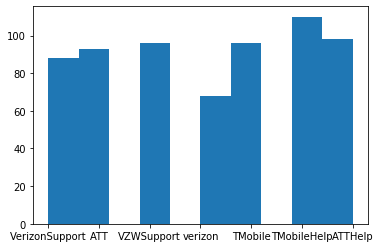

In [16]:
# распределение количества операторов в дф
plt.hist(clean_df['carrier'],align = 'mid')

In [17]:
# распределение по сентиментам
clean_df.groupby('sense_dummy')['carrier'].agg('count')

sense_dummy
-1     91
 0    318
 1    240
Name: carrier, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020434646188>,
      dtype=object)

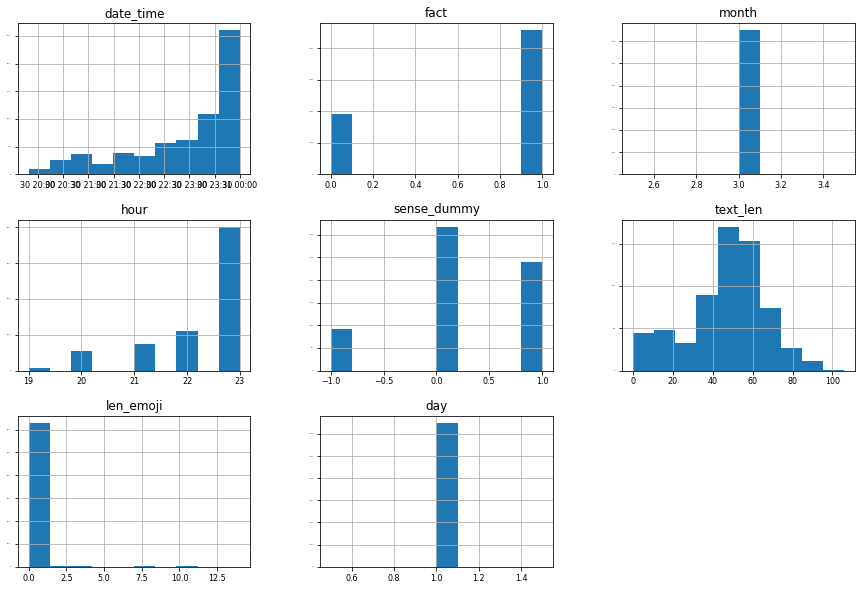

In [18]:
# распределение всех числовых фичей

clean_df.hist(figsize=(15, 10), bins=10, xlabelsize=8, ylabelsize=2)

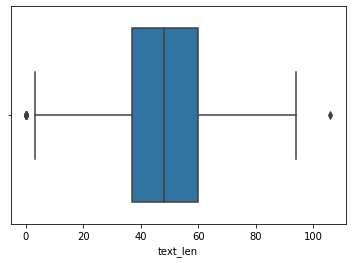

In [19]:
# боксплот по длине слов в корпусе
sns.boxplot(clean_df['text_len'])

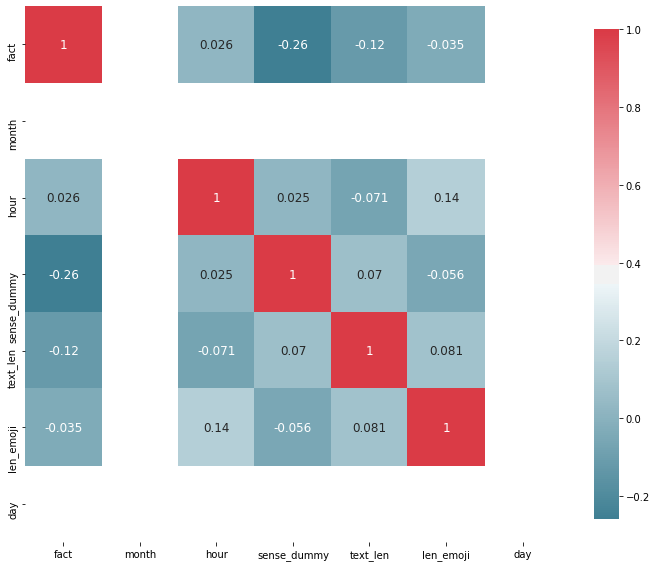

In [21]:
# heatmap - с лекции по numpy
# выделение столбцов для heatmap корреляции
cor_col=['fact','month','hour','text_len','len_emoji','day']
target = clean_df['sense_dummy']

def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )
plot_correlation_map( clean_df )

### Определи, какие слова наиболее характерны для операторов

  * какие cлова чаще, чем остальные встречаются для определенного оператора

In [101]:
# функция подсчета слов для оператора

from collections import Counter


# car = 'VerizonSupport'
# carrier_corpus = []
# for t  in clean_df[clean_df['carrier']== car]['clean_text']:
#     for j in t.split():
#         carrier_corpus.append(j)
        
# total_term_frequency = Counter(carrier_corpus)
# for word, freq in total_term_frequency.most_common(10):
#     word_dist = {}
#     word_dist[word] = freq
# #     print("{}\t{}".format(word, freq))
#     plt.bar(word_dist.keys(), word_dist.values(), color='g')
car = 'VerizonSupport'
def word_frequency_bar(clean_df,carrier_name):
    carrier_corpus = []
    for t  in clean_df[clean_df['carrier']== carrier_name]['clean_text']:
        for j in t.split():
            carrier_corpus.append(j)

    total_term_frequency = Counter(carrier_corpus)
    word_dist = {}
    for word, freq in total_term_frequency.most_common(10):
        word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
        plt.bar(word_dist.keys(), word_dist.values(), color='g')

# word_frequency_bar(clean_df,car)


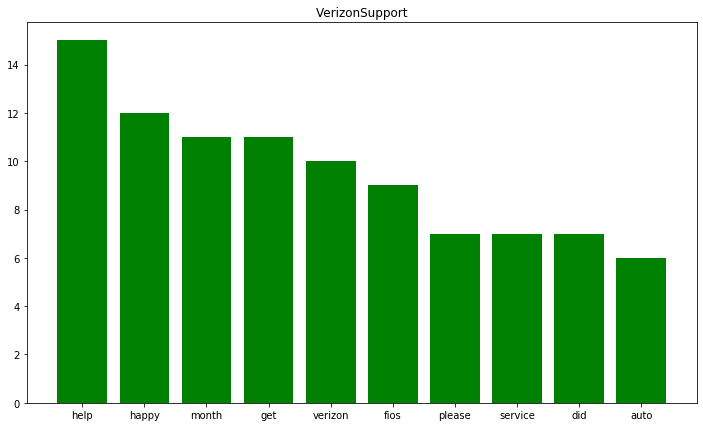

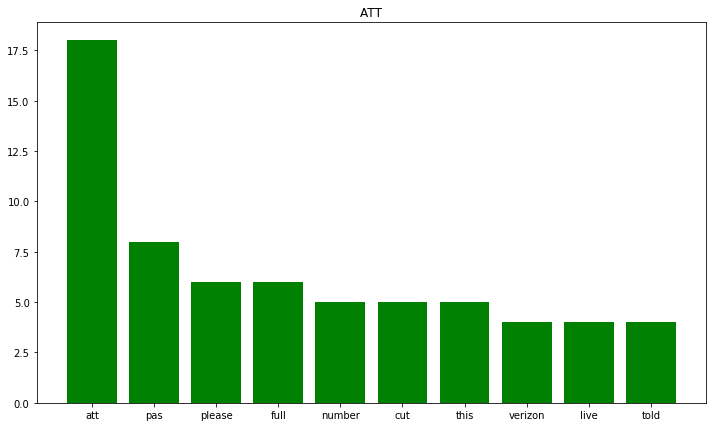

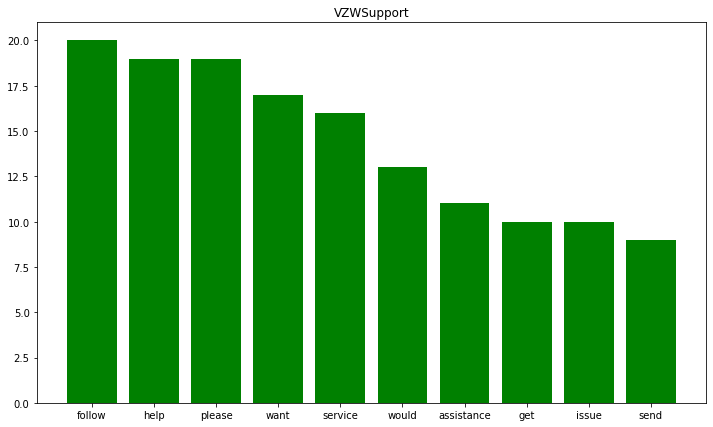

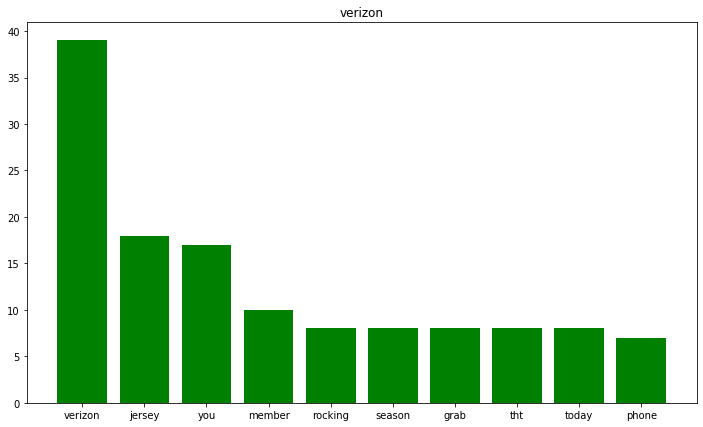

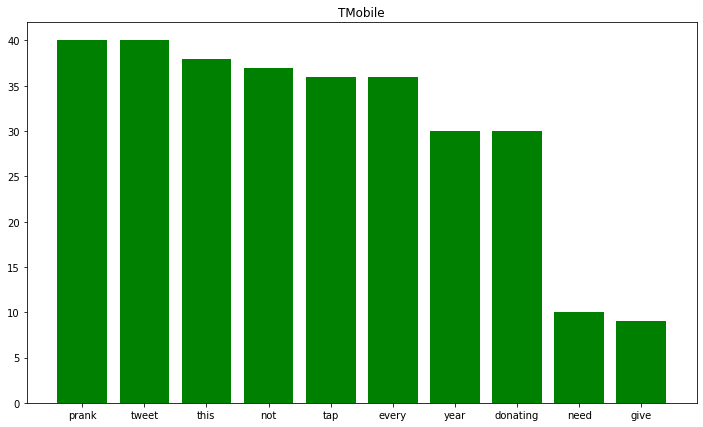

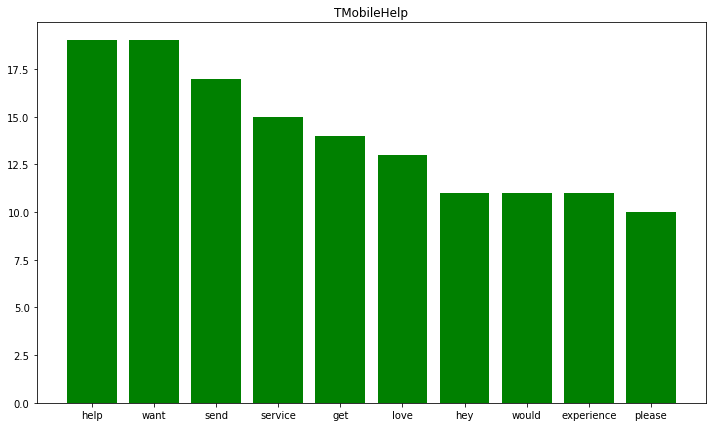

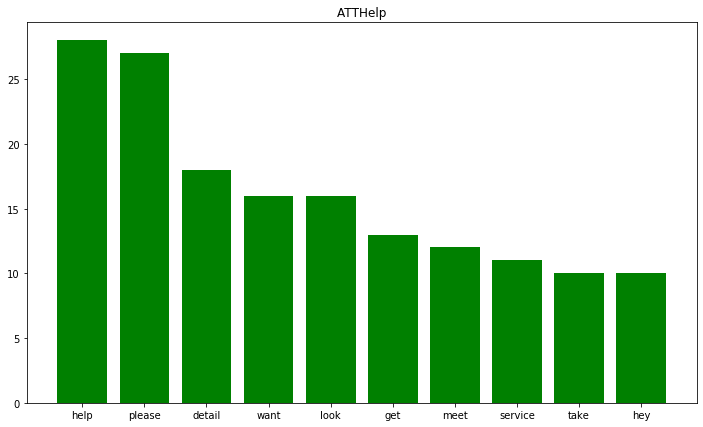

In [23]:
# графики распределения слов для каждого оператора

# fig, axs = plt.subplots(len(clean_df['carrier'].unique()), 1, figsize=(12, 7))
for i in clean_df['carrier'].unique():
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    word_frequency_bar(clean_df,i)
    plt.title(i)

* посмотреть распределения по словам, относительно операторов

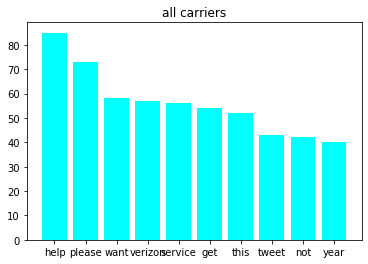

In [24]:
# распределение слов по всем операторам 

all_text = []
for s in  clean_df['clean_text']:
    for j in s.split():
            all_text.append(j)

total_term_frequency = Counter(all_text)
word_dist = {}
for word, freq in total_term_frequency.most_common(10):
    word_dist[word] = freq
#         print ("{}\t{}".format(word, freq))
    plt.bar(word_dist.keys(), word_dist.values(), color='cyan')
    plt.title('all carriers')

In [45]:
# pip install WordCloud

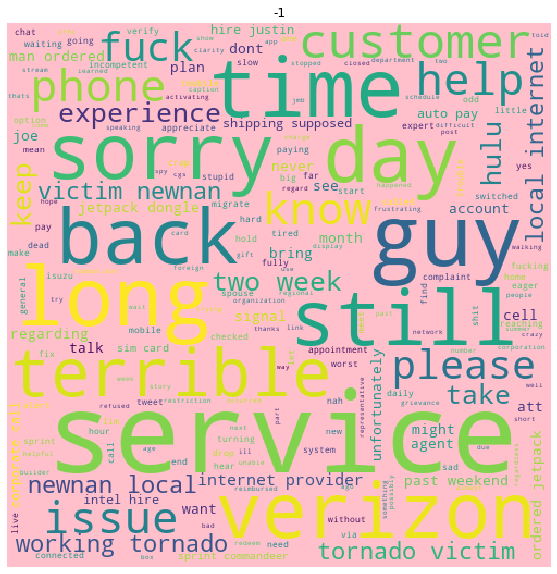

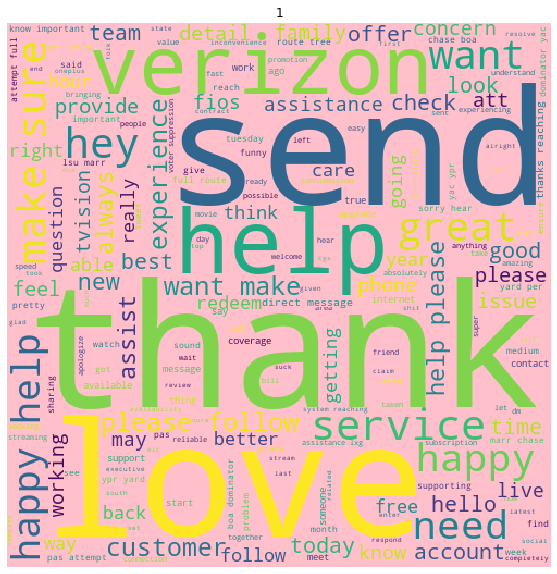

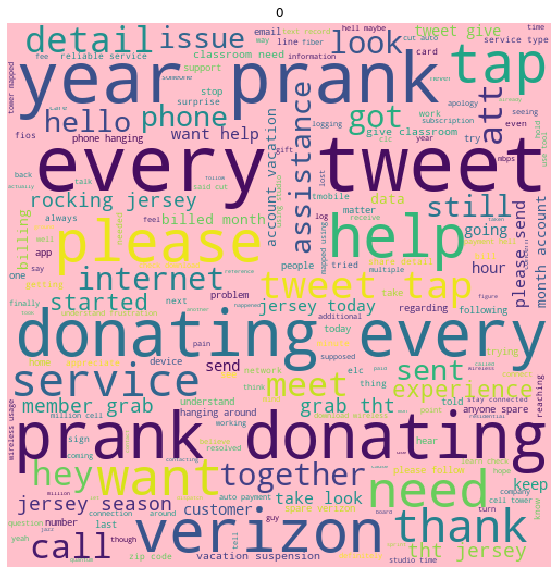

In [41]:
# https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/

# Importing wordcloud for plotting word clouds and textwrap for wrapping longer text
from wordcloud import WordCloud
from textwrap import wrap
def plot_cloud(wordcloud):
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud) 
    plt.axis("off");

for sense in clean_df['sense_dummy'].unique():
    text = ''
    for t in clean_df[clean_df['sense_dummy'] == sense]['clean_text']:
        text+=t+' '
    wordcloud = WordCloud(width = 500, height = 500, background_color='pink', random_state=10).generate(text)
    plot_cloud(wordcloud)
    plt.title(sense)
    


      


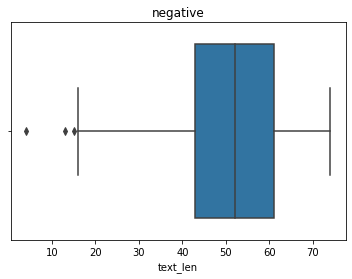

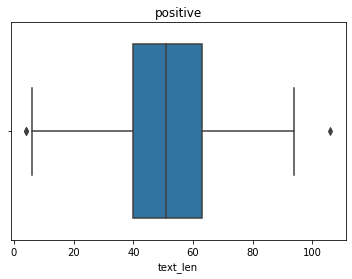

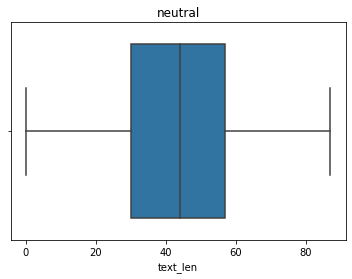

In [25]:
# боксплоты для каждой категории сентимента

for i in clean_df['sense_dummy'].unique():
    plt.figure()
    if i == 1:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('positive')
    elif i == 0:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('neutral')
    else:
        sns.boxplot(clean_df[clean_df['sense_dummy'] == i]['text_len']).set_title('negative')



###  Вопрос 5 . Зачем 2 пункта ниже?
 * пропобуй найти слова: помогите, бесплатно, обещали, покупатель, очень медленно

 * добавь свои слова ( к вышепредставленным) и сделай топ-20

In [26]:
# подсчет  указанных слов

churny_words = ['help','for free','promised','buyer','very slow','switch','change','leave','stay with','bye-bye','can\'t take','horrible','loyal','awful','worth','numbered','contract is up','goodbye','turn','lost']
from collections import defaultdict
churny_words_counter = defaultdict(int)

for word in churny_words:
    for i in clean_df['clean_text']:
        if word in i:
            churny_words_counter[word]+=1
            
churny_words_counter

defaultdict(int,
            {'help': 83,
             'switch': 6,
             'change': 6,
             'leave': 1,
             'loyal': 3,
             'turn': 9,
             'lost': 3})

### Определи время и как время сообщения распределено по времени

* определи месяц, день недели, день месяца, время дня, часть дня (до обеда, день, вечер - например)

In [27]:
# добавим 2 столбца : день месяца и часть дня
clean_df['day_of_month'] = clean_df['date_time'].dt.day
clean_df['part_of_day'] = clean_df['hour'].apply(lambda x: 'night' if 0<x<5 else ('morning' if 6<x<10 else ('day' if 11<x<18 else "evening") ))



(array([  0.,   0.,   0.,   0.,   0., 649.,   0.,   0.,   0.,   0.]),
 array([2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5]),
 <a list of 10 Patch objects>)

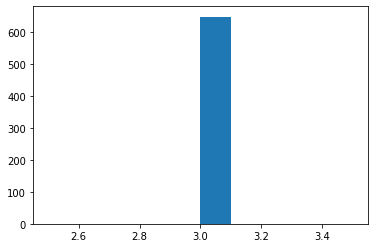

In [28]:
# распределение по месяцам
plt.hist(clean_df['month'])

(array([  0.,   0.,   0.,   0.,   0., 649.,   0.,   0.,   0.,   0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <a list of 10 Patch objects>)

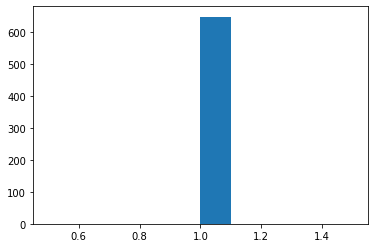

In [29]:
# по дням недели
plt.hist(clean_df['day'])

(array([  0.,   0.,   0.,   0.,   0., 649.,   0.,   0.,   0.,   0.]),
 array([29.5, 29.6, 29.7, 29.8, 29.9, 30. , 30.1, 30.2, 30.3, 30.4, 30.5]),
 <a list of 10 Patch objects>)

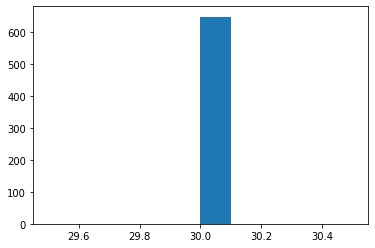

In [30]:
# по числу месяца
plt.hist(clean_df['day_of_month'])

(array([  0.,   0.,   0.,   0.,   0., 649.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

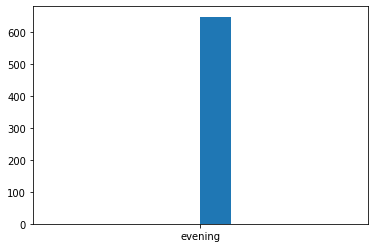

In [31]:
# по периоду дня
plt.hist(clean_df['part_of_day'])

###  Вопрос 5 .какая логика формулы преобразования sin cosine - это перевод в радианы? это потом пойдет в модель

In [32]:
# преобразование циклических данных
import numpy as np

seconds_in_day = 24*60*60
clean_df['seconds']= clean_df['date_time'].dt.second
clean_df['sin_time'] = np.sin(2*np.pi*clean_df.seconds/seconds_in_day)
clean_df['cos_time'] = np.cos(2*np.pi*clean_df.seconds/seconds_in_day)

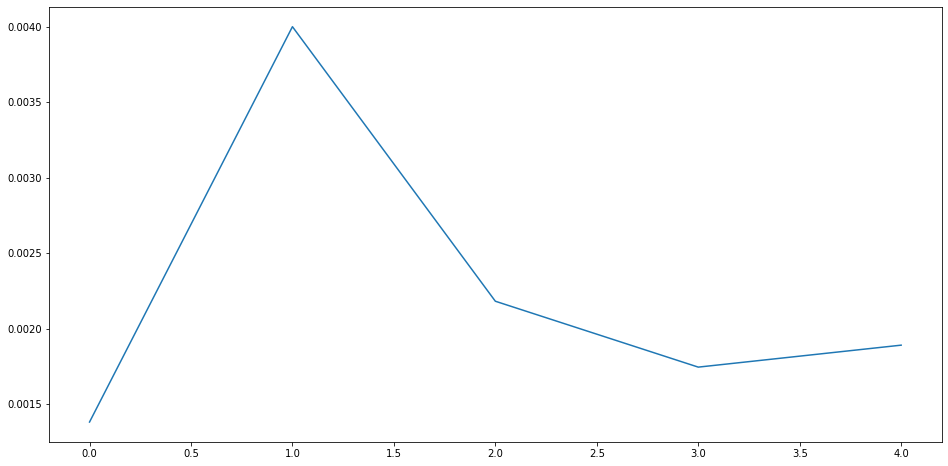

In [33]:
clean_df.sin_time.head(5).plot(figsize = (16,8))

### Сделай распределения и обзор по сентиментному анализу относительно операторов

In [34]:
# посмотрим процентное распределение сентиментов по операторам

from statsmodels.api import stats
df_conflux = clean_df[['carrier','sense_dummy']]
table1 = stats.Table.from_data(df_conflux)
df_conflux = pd.DataFrame(table1.table_orig)
# for i in df_conflux.columns:
#     print(type(i))
#     print(i)
df_conflux['neg %'] = df_conflux[-1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['pos %'] = df_conflux[1]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux['neu %'] = df_conflux[0]/(df_conflux[-1]+df_conflux[1]+df_conflux[0])
df_conflux

sense_dummy,-1,0,1,neg %,pos %,neu %
carrier,,,,,,
ATT,10,51,32,0.107527,0.344086,0.548387
ATTHelp,11,63,24,0.112245,0.244898,0.642857
TMobile,4,68,24,0.041667,0.250000,0.708333
TMobileHelp,23,24,63,0.209091,0.572727,0.218182
VZWSupport,19,36,41,0.197917,0.427083,0.375000
VerizonSupport,15,35,38,0.170455,0.431818,0.397727
verizon,9,41,18,0.132353,0.264706,0.602941


In [35]:
clean_df.to_csv('clean_df.csv')


### Создание репрезентативного словаря для негативны и позитивных твитов

In [36]:
# токенизация очищенного текста

# https://github.com/hundredblocks/concrete_NLP_tutorial/blob/master/NLP_notebook.ipynb

from nltk.tokenize import RegexpTokenizer



clean_df["tokens"] = clean_df["clean_text"].apply(tokenizer.tokenize)
all_words = [word for tokens in clean_df["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_df["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

4776 words total, with a vocabulary size of 1414
Max sentence length is 15


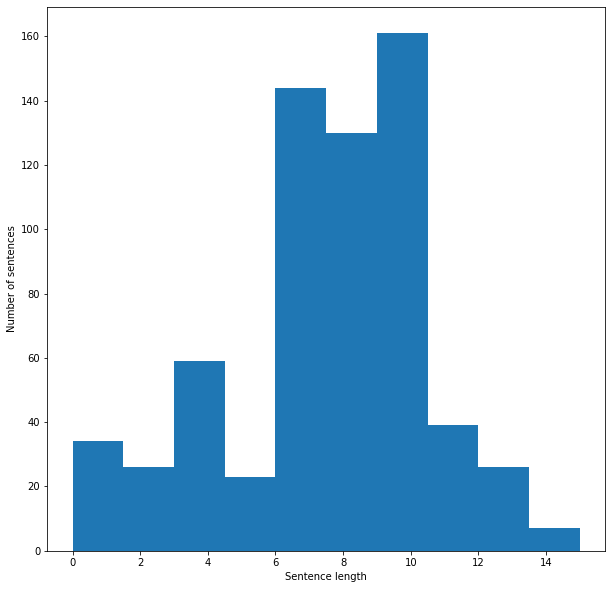

In [37]:
# распределение предложений по длине
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

In [38]:
# Bag of words
# https://habr.com/ru/company/Voximplant/blog/446738/

# Import the libraries we need
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Step 2. Design the Vocabulary
# The default token pattern removes tokens of a single character. That's why we don't have the "I" and "s" tokens in the output
count_vectorizer = CountVectorizer()

# Step 3. Create the Bag-of-Words Model
bag_of_words = count_vectorizer.fit_transform(clean_df['clean_text'])

# Show the Bag-of-Words Model as a pandas DataFrame
feature_names = count_vectorizer.get_feature_names()
pd.DataFrame(bag_of_words.toarray(), columns = feature_names)


,able,absolutely,acce,access,account,across,acting,activating,active,actually,...,yikes,you,your,yours,youtube,ypr,yr,zip,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
644,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
645,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# топ-10 слов
stops =  set(stopwords.words('english')+['com'])
co = CountVectorizer(stop_words=stops)
counts = co.fit_transform(clean_df.clean_text)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)

,0
help,85
please,73
want,58
verizon,57
service,56
get,54
tweet,43
year,40
need,40
prank,40


In [40]:
# топ-10 биграмм
co = CountVectorizer(ngram_range=(2,2),stop_words=stops)
counts = co.fit_transform(clean_df.clean_text)
pd.DataFrame(counts.sum(axis=0),columns=co.get_feature_names()).T.sort_values(0,ascending=False).head(10)

,0
every tweet,36
donating every,30
prank donating,30
tap year,30
year prank,30
please follow,19
help please,18
make sure,16
happy help,13
want make,13


In [42]:
sense_dict = {}
for sense in clean_df['sense_dummy'].unique():
    print(sense)
    text = ''
    for i in clean_df[clean_df['sense_dummy'] == sense]['clean_text'].values:
#         print(i)
        text+=i+''
        sense_dict[sense] = text.split()
freq_dist_positive=nltk.FreqDist(sense_dict[1])
freq_dist_negative=nltk.FreqDist(sense_dict[-1])
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))      

-1
1
0
Most Common Positive Words :  [('help', 39), ('please', 32), ('send', 22), ('happy', 18), ('want', 18), ('make', 18), ('follow', 17), ('get', 17), ('sure', 16), ('love', 16), ('verizon', 15), ('service', 15), ('need', 14), ('thanks', 14), ('would', 13), ('message', 11), ('customer', 11), ('experience', 10), ('team', 10), ('new', 10)]
Most Common Negative Words :  [('service', 17), ('guy', 8), ('back', 7), ('long', 7), ('day', 6), ('verizon', 6), ('internet', 6), ('time', 6), ('issue', 5), ('week', 5), ('get', 5), ('two', 5), ('still', 5), ('sprint', 5), ('have', 4), ('past', 4), ('pay', 4), ('you', 4), ('terrible', 4), ('please', 4)]


In [43]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (649, 4309)
the number of unique words including both unigrams and bigrams  4309


#### TF-IDF

In [44]:
# https://github.com/Ashwani018/Amazon-Fine-Food-Reviews/blob/master/Amazon%20Fine%20Food%20Reviews%20Analysis.ipynb

from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (649, 4309)
the number of unique words including both unigrams and bigrams  4309


In [45]:
features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[4102:4110])

some sample features(unique words in the corpus) ['wayne batman', 'web', 'week', 'week able', 'week and', 'week get', 'week got', 'week later']


In [46]:
# топ-25 значимых по tf-idf слов и биграмм

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(final_tf_idf[1,:].toarray()[0],features,25)
top_tfidf

,feature,tfidf
0,could due,0.275574
1,regional restriction,0.275574
2,have checked,0.275574
3,checked cgs,0.275574
4,this could,0.275574
5,due regional,0.275574
6,restriction have,0.275574
7,restriction,0.275574
8,regional,0.275574
9,checked,0.259103


In [311]:
# unknown word?????

# import tqdm
# words = pd.read_table('https://raw.githubusercontent.com/dwyl/english-words/master/words.txt')
# words.columns=['word']
# non_list = {}
# for sent in tqdm.tqdm(clean_df.clean_text.str.split().values):
#     for token in sent:
#         if token not in words:
#               non_list[token] = 1 if token not in non_list else non_list[token]+1
# pd.Series(non_list).sort_values(ascending=False).head(30)


### Method2: Get representative words by Topic Modeling¶

In [323]:
# pip install gensim

  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.15
    Uninstalling Cython-0.29.15:
      Successfully uninstalled Cython-0.29.15
Note: you may need to restart the kernel to use updated packages.


In [107]:
# выделение топиков по сентиментам
# https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

# # для метода Topic Modeling понадобятся библиотеки
from gensim.corpora import Dictionary
from gensim.models import LdaModel, LdaMulticore
from gensim.models import TfidfModel
import nltk
for sense in clean_df['sense_dummy'].unique():
    pos = []
    for i in clean_df[clean_df['sense_dummy'] == sense]['tokens'].values:
        pos.append(i)
        
    dic=Dictionary(pos)
    bow_corpus = [dic.doc2bow(doc) for doc in pos]
    lda_model = LdaMulticore(bow_corpus, 
                                           num_topics = 4, 
                                           id2word = dic,                                    
                                           passes = 10,
                                           workers = 2)
    print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
    print(lda_model.show_topics())
    

C:\Users\au00174\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()
C:\Users\au00174\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


neg
[(0, '0.024*"guy" + 0.016*"verizon" + 0.016*"time" + 0.015*"issue" + 0.015*"long" + 0.012*"sprint" + 0.012*"back" + 0.012*"hire" + 0.012*"intel" + 0.012*"bring"'), (1, '0.024*"internet" + 0.020*"phone" + 0.017*"sorry" + 0.017*"get" + 0.017*"victim" + 0.017*"provider" + 0.017*"tornado" + 0.017*"newnan" + 0.017*"working" + 0.017*"local"'), (2, '0.025*"service" + 0.014*"customer" + 0.011*"terrible" + 0.009*"day" + 0.009*"hulu" + 0.009*"card" + 0.009*"past" + 0.009*"sim" + 0.009*"weekend" + 0.009*"shipping"'), (3, '0.025*"service" + 0.021*"week" + 0.017*"and" + 0.017*"fuck" + 0.017*"two" + 0.013*"call" + 0.013*"time" + 0.013*"have" + 0.013*"back" + 0.013*"still"')]
pos
[(0, '0.014*"good" + 0.013*"want" + 0.012*"thanks" + 0.011*"service" + 0.011*"verizon" + 0.009*"phone" + 0.009*"make" + 0.007*"new" + 0.007*"say" + 0.007*"internet"'), (1, '0.015*"hey" + 0.013*"thanks" + 0.010*"best" + 0.010*"love" + 0.010*"great" + 0.010*"service" + 0.009*"would" + 0.009*"experience" + 0.008*"reaching" 

In [108]:
# попытка визуализации
import pyLDAvis


pyLDAvis.enable_notebook()
vis = pyLDAvis.prepare(lda_model, bow_corpus, dic)
vis

TypeError: prepare() missing 2 required positional arguments: 'vocab' and 'term_frequency'

In [65]:
pip install --user gensim

Note: you may need to restart the kernel to use updated packages.


In [317]:
# общие топики по всему корпусу

# https://dair.ai/Exploratory_Data_Analysis_for_Text_Data/


from sklearn.decomposition import LatentDirichletAllocation, NMF
vectorizer = CountVectorizer(stop_words=stops)
model = vectorizer.fit(clean_df.clean_text)
docs = vectorizer.transform(clean_df.clean_text)
lda = LatentDirichletAllocation(20)
lda.fit(docs)
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([(feature_names[i])
        for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
print_top_words(lda,vectorizer.get_feature_names(),10)

Topic #0: call week service fuck still last verizon two issue cell
Topic #1: verizon phone get call billing around anyone hanging spare wireless
Topic #2: reaching hear service still check try issue please thanks appreciate
Topic #3: please detail thank want help service send get family share
Topic #4: tweet prank every tap year donating give need classroom thanks
Topic #5: get started know code follow customer please want month taken
Topic #6: help get need following new problem getting paid tvision finally
Topic #7: verizon pas card gift att one good time fios left
Topic #8: account month love would someone suspension vacation billed help long
Topic #9: internet use working getting want need experience keep local tool
Topic #10: verizon team full per pas yard lsu yac tree boa
Topic #11: back meet phone wait alexisdean replied always please hour thanks
Topic #12: att service day need issue supposed hello phone support guy
Topic #13: jersey today member season rocking tht grab network 

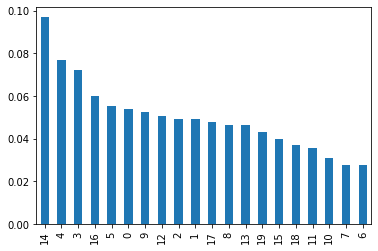

In [319]:
# распределение по количеству топиков

clean_df['topic']=lda.transform(docs).argmax(axis=1)
clean_df.topic.value_counts(normalize=True).plot.bar()

In [320]:


# for i in range(10):
#     temp = clean_df[clean_df.topic==i]
#     temp.resample('7D').size().plot()
#     plt.title('topic %s' %i)
#     plt.show()

TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Int64Index'

### Named entity recognition

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [102]:
#  pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

In [47]:
import spacy

nlp = spacy.load("en_core_web_sm")

In [99]:
# doc=nlp('India and Iran have agreed to boost the economic viability \
# of the strategic Chabahar port through various measures, \
# including larger subsidies to merchant shipping firms using the facility, \
# people familiar with the development said on Thursday.')

# [(x.text,x.label_) for x in doc.ents]
# from spacy import displacy

# displacy.render(doc, style='ent')

In [51]:
# создание корпусов по сентиментам

# pos_text = ''
# neg_text = ''
# neu_text = ''
# for i in clean_df['sense_dummy'].unique():
    
#     for text in clean_df[clean_df['sense_dummy'] == i]['clean_text']:
#         if i == -1:
#             neg_text+=text+' '
#         elif i == 0:
#             neu_text+=text+' '
#         else:
#             pos_text+=text+' '
            

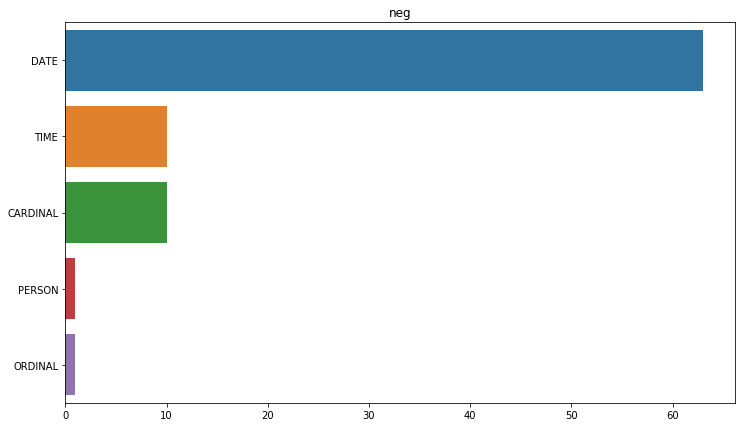

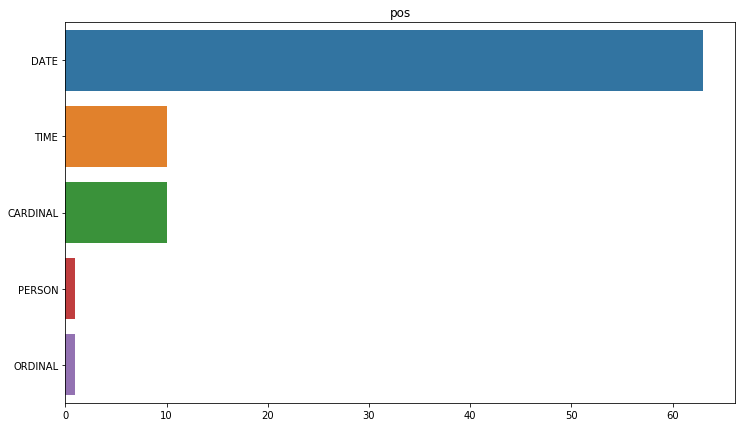

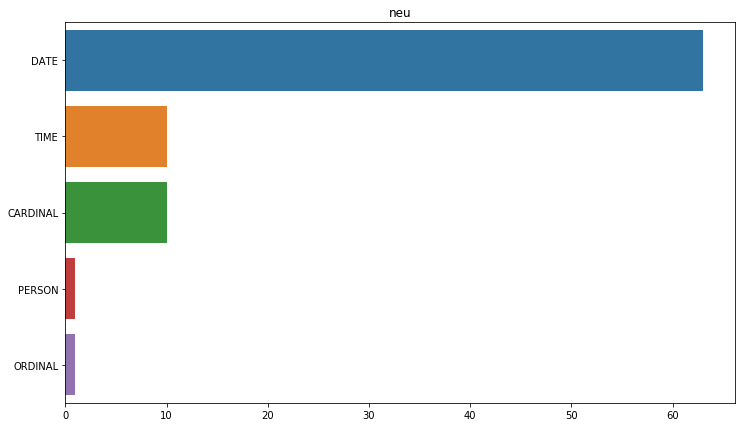

In [64]:
# распределение entity по сенитментам

def ner(text):
    doc=nlp(text)
    return [X.label_ for X in doc.ents]
for sense in clean_df['sense_dummy'].unique():
    ent=clean_df[clean_df['sense_dummy'] == i]['clean_text'].apply(lambda x : ner(x))
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    x,y=map(list,zip(*count))
#     print('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))
    sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))


https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools
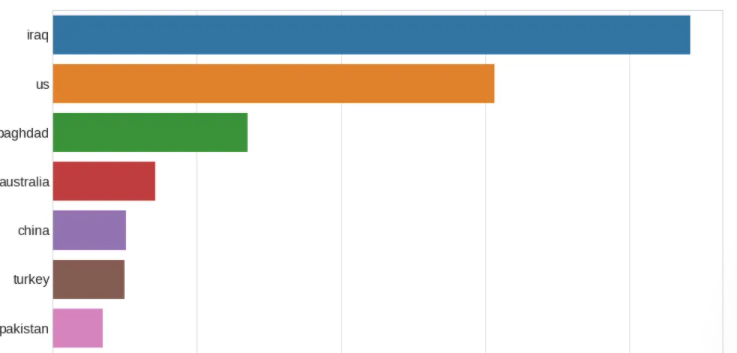

### Exploration through parts of speach tagging in Python

https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

In [103]:
# nltk.download('averaged_perceptron_tagger')

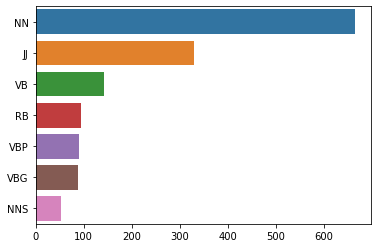

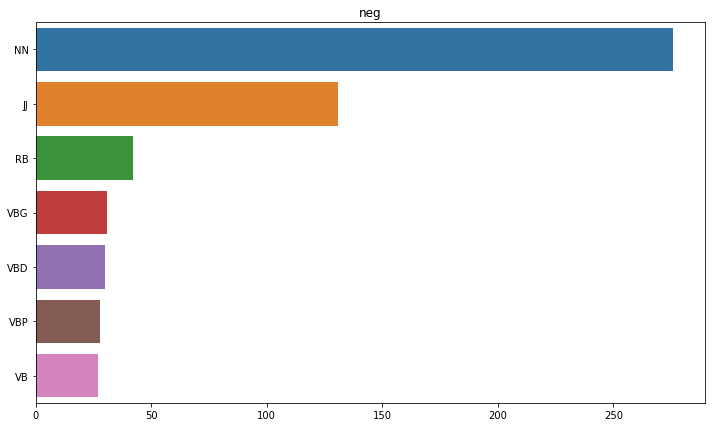

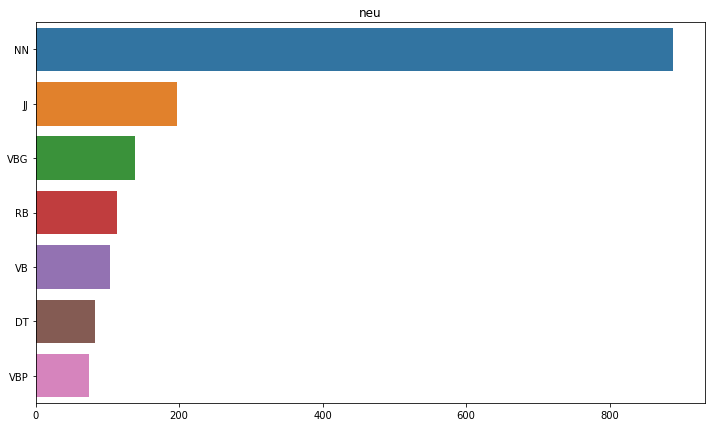

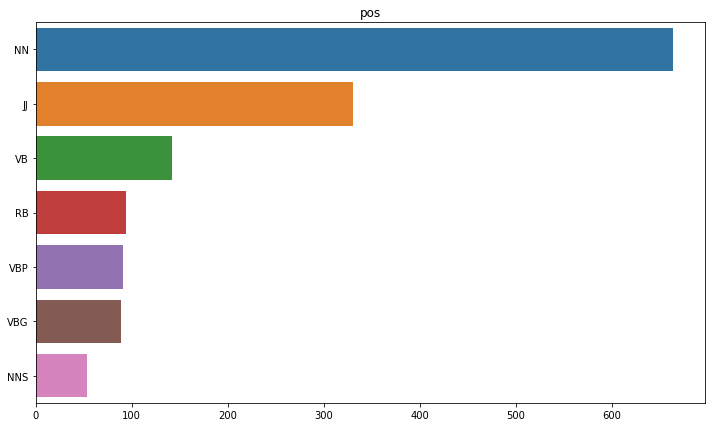

In [94]:
# распределение по частям предложения

def pos(text):
    pos=nltk.pos_tag(word_tokenize(text))
    pos=list(map(list,zip(*pos)))[1]
    return pos

# tags=news['headline_text'].apply(lambda x : pos(x))
# tags=[x for l in tags for x in l]
# counter=Counter(tags)

x,y=list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)
for sense in range(-1,2):
#     print(i)
    tags = [i[1] for i in nltk.pos_tag(sense_dict[sense])]
    freq_dist_positive=nltk.FreqDist(tags)
#     print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
    counter=Counter(tags)
    x,y=list(map(list,zip(*counter.most_common(7))))
    fig, axs = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x=y,y=x).set_title('pos' if sense== 1 else  ('neg' if sense == -1 else 'neu'))

In [105]:
# doc = nlp('The greatest comeback stories in 2019')
# displacy.render(doc, style='dep', jupyter=True, options={'distance': 90})

### Exploring through text complexity
https://neptune.ai/blog/exploratory-data-analysis-natural-language-processing-tools

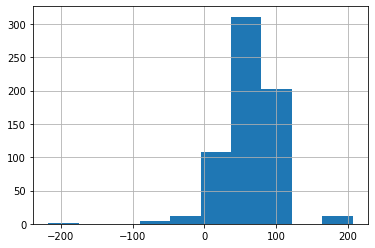

In [97]:

from textstat import flesch_reading_ease

clean_df['clean_text'].apply(lambda x : flesch_reading_ease(x)).hist()

In [98]:
# pip install textstat

###  Вопрос ГЛАВНЫЙ - корректно ли выполнен EDA, есть ли комментарии, что добавить и как продолжать? 